In [2]:
# Imports here
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter 
import csv
from tqdm import tqdm


from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
data_dir = '../dataset'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'



In [5]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])


trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

testset = torchvision.datasets.ImageFolder(root=valid_dir, transform=test_transforms)
validloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=0)

In [15]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 56 * 56, 512)  # Adjusted this line
        self.fc2 = nn.Linear(512, 102)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [16]:
import torch
import torch.nn as nn
import torchvision


class DeformableCNNModel(nn.Module):
    def __init__(self):
        super(DeformableCNNModel, self).__init__()

        # Convolutional weights
        self.weight1 = nn.Parameter(torch.Tensor(32, 3, 3, 3))
        self.weight2 = nn.Parameter(torch.Tensor(64, 32, 3, 3))
        self.weight3 = nn.Parameter(torch.Tensor(128, 64, 3, 3))
        nn.init.kaiming_uniform_(self.weight1, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.weight2, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.weight3, nonlinearity='relu')

        # Bias terms (if you want to include biases)
        self.bias1 = nn.Parameter(torch.Tensor(32))
        self.bias2 = nn.Parameter(torch.Tensor(64))
        self.bias3 = nn.Parameter(torch.Tensor(128))
        self.bias1.data.fill_(0)
        self.bias2.data.fill_(0)
        self.bias3.data.fill_(0)

        # Offset (and mask if required) for deformable convolution
        self.offsets1 = nn.Conv2d(3, 2*3*3, kernel_size=3, padding=1, stride=1)
        self.offsets2 = nn.Conv2d(32, 2*3*3, kernel_size=3, padding=1, stride=1)
        self.offsets3 = nn.Conv2d(64, 2*3*3, kernel_size=3, padding=1, stride=1)
        
        # Rest of the model remains similar
        self.pool = nn.MaxPool2d(2, 2)
        # Calculate correct size for the fully connected layer
        self.fc1 = nn.Linear(128 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, 102)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torchvision.ops.deform_conv2d(x, self.offsets1(x), self.weight1, self.bias1, padding=1)
        x = self.relu(x)
        
        x = self.pool(x)
        x = torchvision.ops.deform_conv2d(x, self.offsets2(x), self.weight2, self.bias2, padding=1)
        x = self.relu(x)
        
        x = self.pool(x)
        x = torchvision.ops.deform_conv2d(x, self.offsets3(x), self.weight3, self.bias3, padding=1)
        x = self.relu(x)
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


In [17]:
class TransferLearningModel(nn.Module):
    def __init__(self):
        super(TransferLearningModel, self).__init__()
        # Use a pre-trained model as the convolutional base
        self.resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(self.resnet.children())[:-1])
        
        # New fully connected layers for classification
        self.fc1 = nn.Linear(2048, 512)  # Adjusted to match ResNet50's output
        self.fc2 = nn.Linear(512, 102)   # Assuming 102 classes for classification
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass input through the pre-trained model's convolutional layers
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


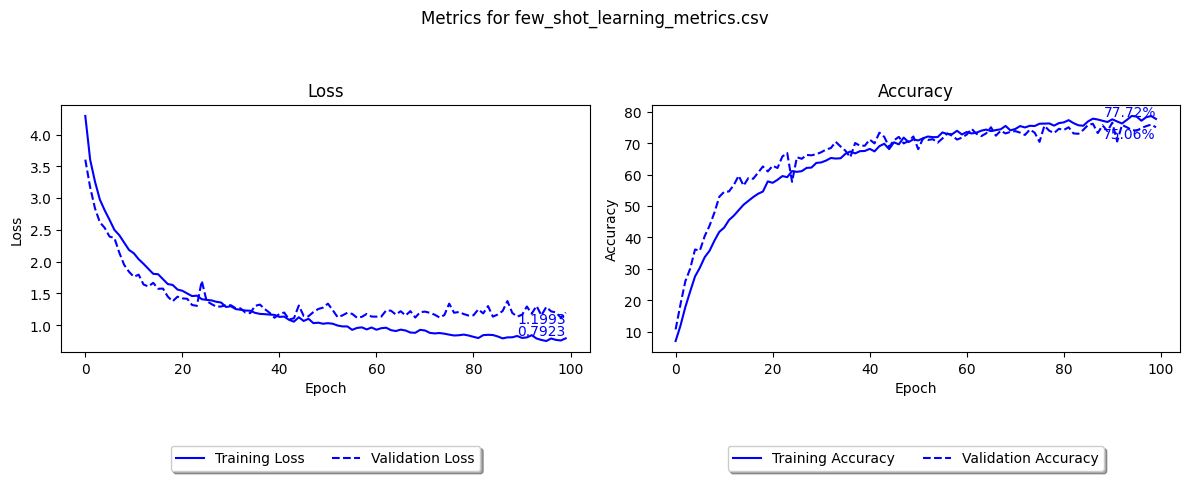

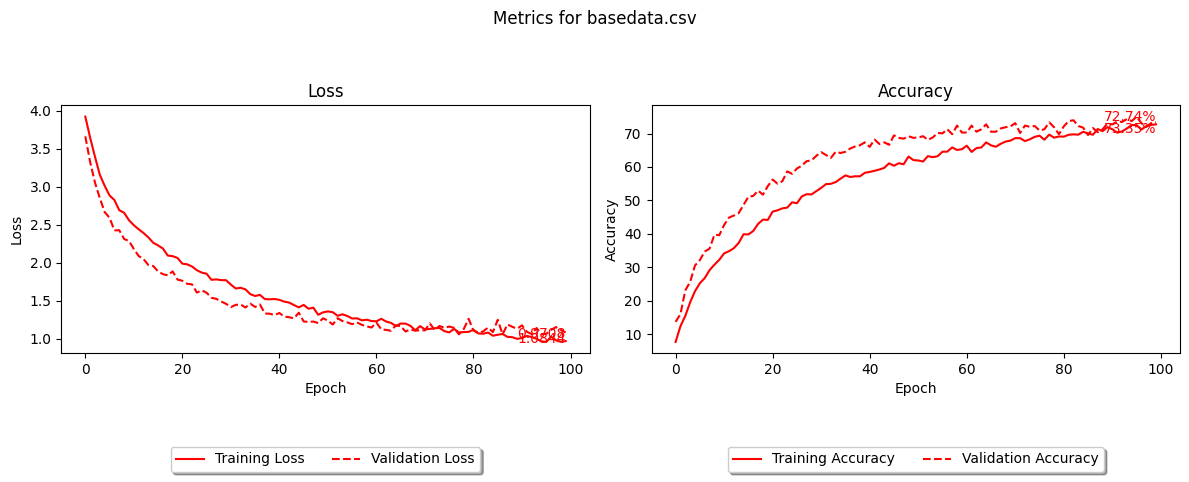

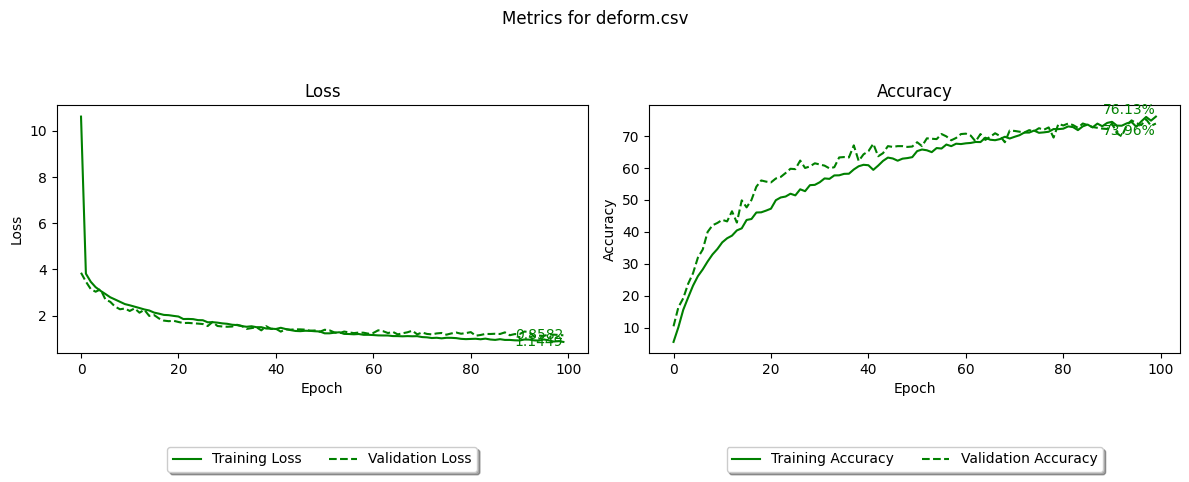

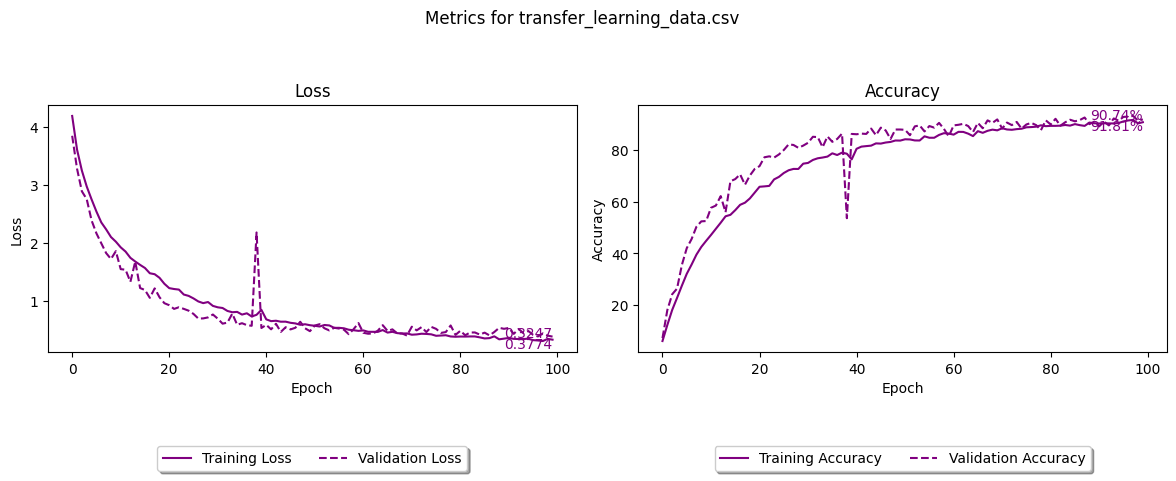

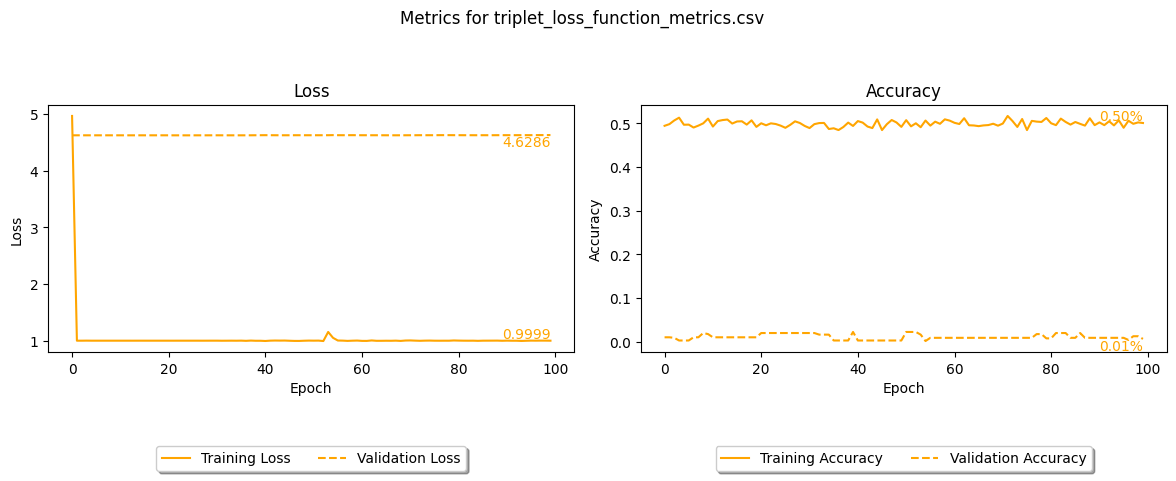

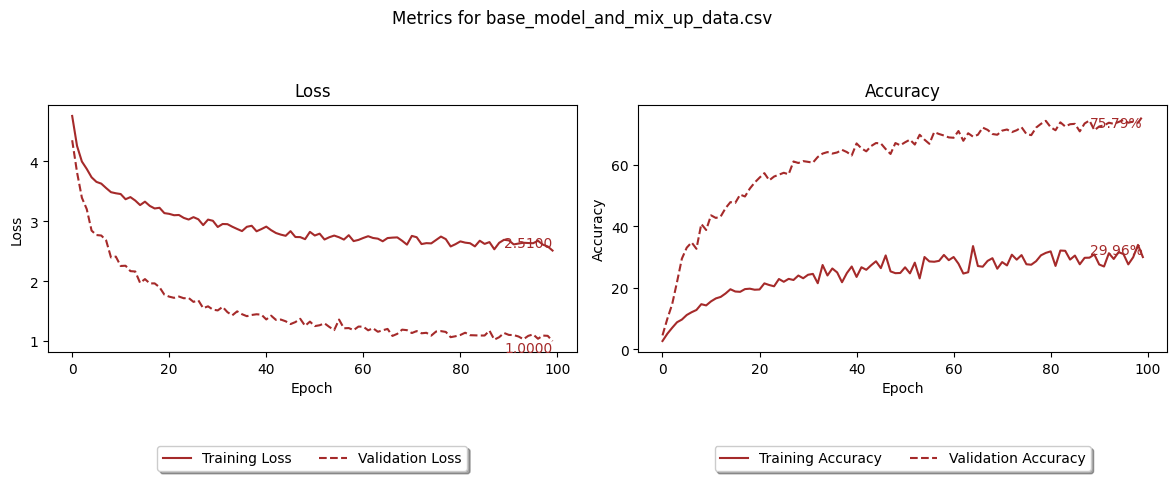

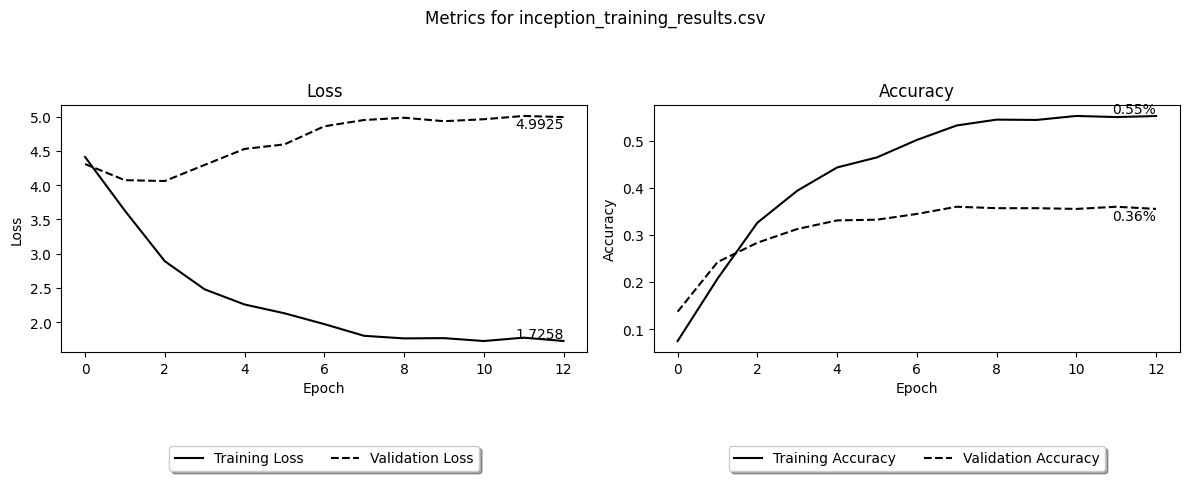

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(csv_file, color):
    df = pd.read_csv(csv_file)
    
    # Extract the necessary data
    train_losses = df['Training Loss']
    valid_losses = df['Validation Loss']
    train_accuracies = df['Training Accuracy']
    valid_accuracies = df['Validation Accuracy']
    
    # Get the last epoch's values for labels
    last_epoch_index = len(train_losses) - 1
    last_train_loss = train_losses.iloc[-1]
    last_valid_loss = valid_losses.iloc[-1]
    last_train_accuracy = train_accuracies.iloc[-1]
    last_valid_accuracy = valid_accuracies.iloc[-1]
    
    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color=color)
    plt.plot(valid_losses, label='Validation Loss', color=color, linestyle='--')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), fancybox=True, shadow=True, ncol=2)
    plt.text(last_epoch_index, last_train_loss, f'{last_train_loss:.4f}', ha='right', color=color, verticalalignment='bottom')
    plt.text(last_epoch_index, last_valid_loss, f'{last_valid_loss:.4f}', ha='right', color=color, verticalalignment='top')

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color=color)
    plt.plot(valid_accuracies, label='Validation Accuracy', color=color, linestyle='--')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), fancybox=True, shadow=True, ncol=2)
    plt.text(last_epoch_index, last_train_accuracy, f'{last_train_accuracy:.2f}%', ha='right', color=color, verticalalignment='bottom')
    plt.text(last_epoch_index, last_valid_accuracy, f'{last_valid_accuracy:.2f}%', ha='right', color=color, verticalalignment='top')

    # Show the plot with a title for the CSV file
    plt.suptitle(f'Metrics for {csv_file}', y=1.05)
    plt.tight_layout()
    plt.show()

csv_files = [
    ('few_shot_learning_metrics.csv', 'blue'),
    ('basedata.csv', 'red'),
    ('deform.csv', 'green'),
    ('transfer_learning_data.csv', 'purple'),
    ('triplet_loss_function_metrics.csv', 'orange'),
    ('base_model_and_mix_up_data.csv', 'brown'),
    ('inception_training_results.csv', 'black')
    
    
]

for file_name, color in csv_files:
    plot_metrics(file_name, color)


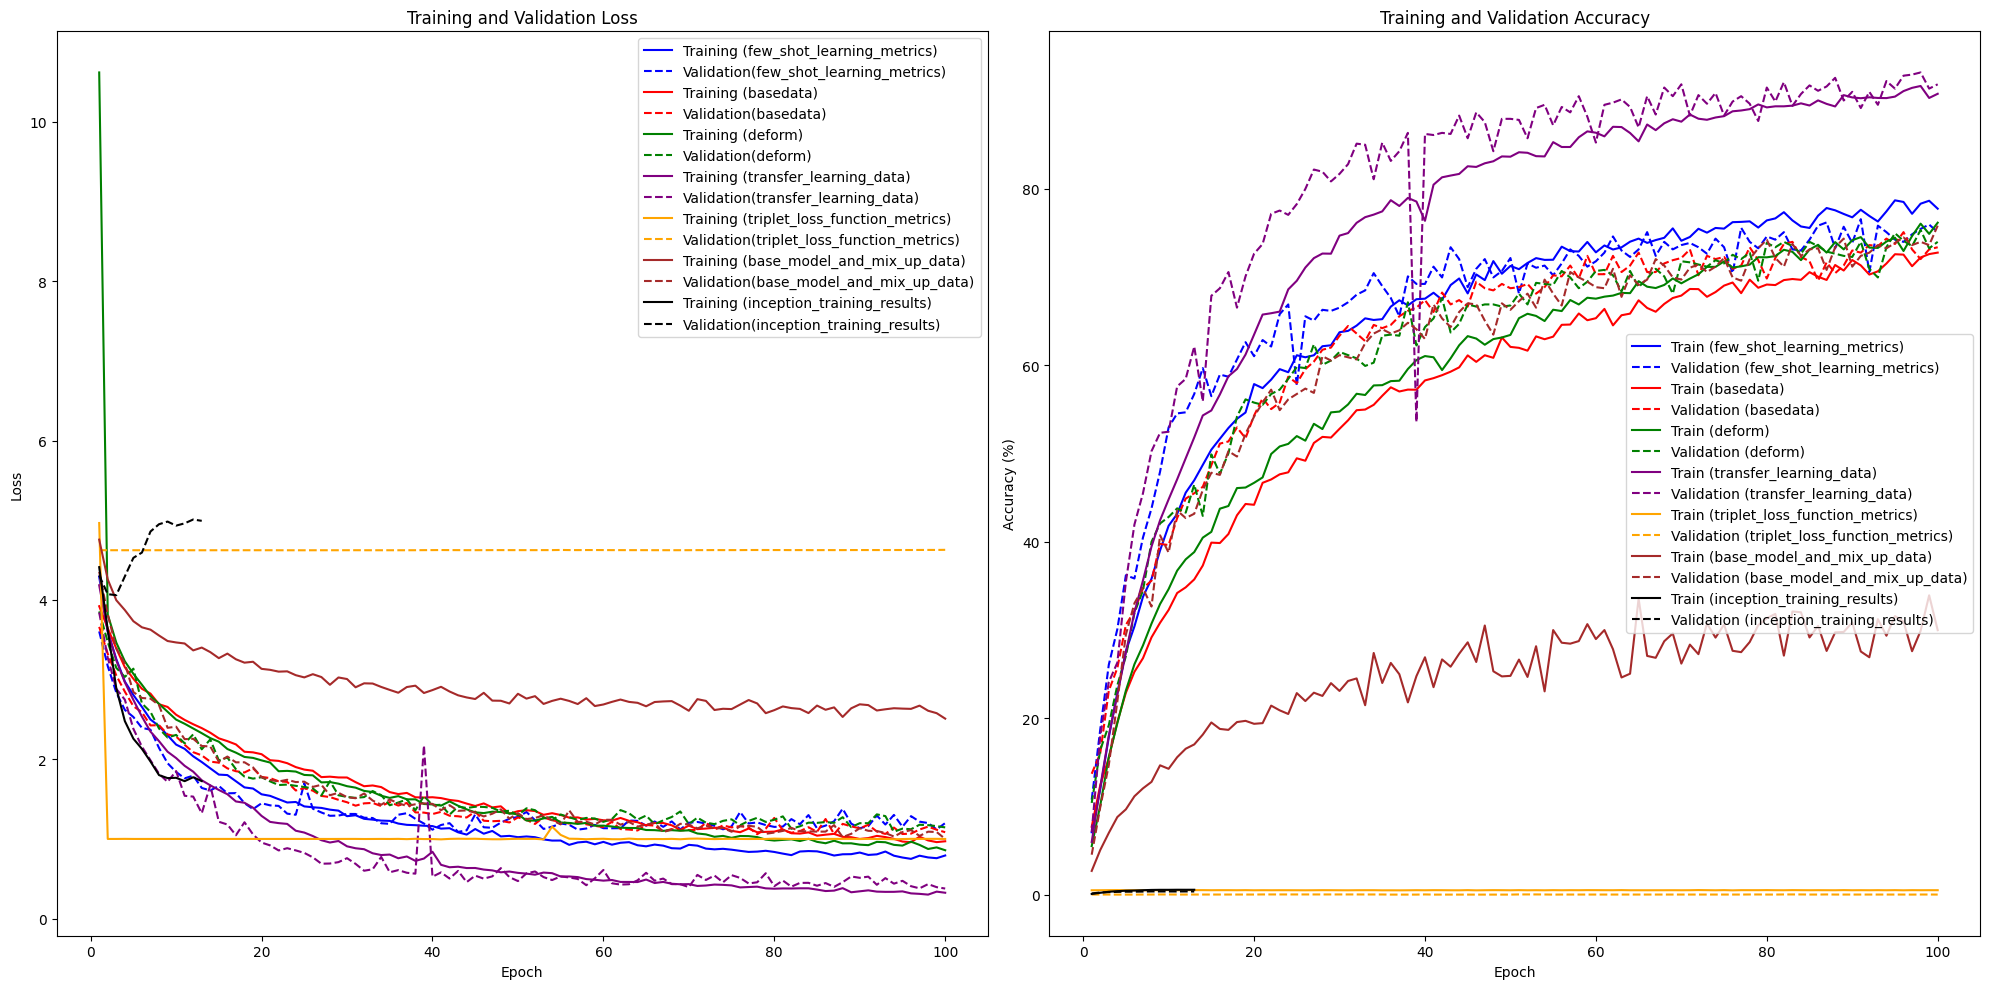

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# List of CSV files and corresponding colors
csv_files = [
    ('few_shot_learning_metrics.csv', 'blue'),
    ('basedata.csv', 'red'),
    ('deform.csv', 'green'),
    ('transfer_learning_data.csv', 'purple'),
    ('triplet_loss_function_metrics.csv', 'orange'),
    ('base_model_and_mix_up_data.csv', 'brown'),
    ('inception_training_results.csv', 'black')
    
    
]

# Create an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# Read and combine data from each CSV file
for csv_file, color in csv_files:
    df = pd.read_csv(csv_file)
    combined_df = pd.concat([combined_df, df])

# Extract the data from the combined DataFrame
epoch = combined_df['Epoch']
train_losses = combined_df['Training Loss']
valid_losses = combined_df['Validation Loss']
train_accuracies = combined_df['Training Accuracy']
valid_accuracies = combined_df['Validation Accuracy']

# Create subplots
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
for i, (csv_file, color) in enumerate(csv_files):
    df = pd.read_csv(csv_file)
    # Extract the file name without the extension
    file_name = os.path.splitext(os.path.basename(csv_file))[0]
    plt.plot(df['Epoch'], df['Training Loss'], label=f'Training ({file_name})', color=color)
    plt.plot(df['Epoch'], df['Validation Loss'], label=f'Validation({file_name})', linestyle='--', color=color)

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
for i, (csv_file, color) in enumerate(csv_files):
    df = pd.read_csv(csv_file)
    # Extract the file name without the extension
    file_name = os.path.splitext(os.path.basename(csv_file))[0]
    plt.plot(df['Epoch'], df['Training Accuracy'], label=f'Train ({file_name})', color=color)
    plt.plot(df['Epoch'], df['Validation Accuracy'], label=f'Validation ({file_name})', linestyle='--', color=color)

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()


BASE MODEL

In [ ]:
model1 = CNNModel()
#model.load_state_dict(torch.load('/Users/takash/Documents/GitHub/SC4001-Assignment-2/Models/base.pth', map_location=device))
model1 = torch.load('./Models/base_model.pth', map_location=torch.device('cpu'))

# If you also saved other attributes like optimizer state
model1.state_dict()

# Switch the model to evaluation mode
model1.eval()

In [ ]:
correct_valid = 0
total_valid = 0

with torch.no_grad():
    for inputs, labels in validloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model1(inputs)

        _, predicted = torch.max(outputs, 1)
        total_valid += labels.size(0)
        correct_valid += (predicted == labels).sum().item()

valid_accuracy_basemodel = 100 * correct_valid / total_valid
print(f"Validation Accuracy: {valid_accuracy_basemodel:.2f}%")

Validation Accuracy: 3.42%


FEW SHOT LEARNING MODEL

In [ ]:
model2 = CNNModel()

# Load the trained model's state dictionary

model2 = torch.load('few_shot_learning_model.pth').to(device)

model2.state_dict()

# Switch the model to evaluation mode
model2.eval()

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)

In [ ]:
model2.eval()
correct = 0
total = 0
with torch.no_grad():
  for support_set, query_set in validloader:
      support_set, query_set = support_set.to(device), query_set.to(device)
      embeddings = model2(support_set)
      _, predicted = torch.max(embeddings, 1)
      total += query_set.size(0)
      correct += (predicted == query_set).sum().item()
print('Validation Accuracy of Few-shot learning model : %d %%' % (100 * correct / total))

Training Accuracy of Few-shot learning model : 75 %


TRANSFER LEARNING MODEL

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models  # Import PyTorch models
#from your_model_module import TransferLearningModel  # Import your TransferLearningModel from your model module

# Create an instance of your model
model3 = TransferLearningModel()

# Load the trained model's state dictionary
state_dict = torch.load('transfer_learning_model.pth', map_location=device)

# Load the state dictionary into the model
model3.load_state_dict(state_dict)

# Move the model to the desired device
model3 = model3.to(device)

# Switch the model to evaluation mode
model3.eval()


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TransferLearningModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [ ]:
train_correct = 0
train_total = 0

# Assuming you have a trainloader for the training dataset
with torch.no_grad():
    for inputs, labels in validloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model3(inputs)

        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

train_accuracy_transfer_learning = 100 * train_correct / train_total
print(f"Validation Accuracy of Transfer Learning Model: {train_accuracy_transfer_learning:.2f}%")


Validation Accuracy of Transfer Learning Model: 3.91%


BASE MODEL & MIX UP MODEL

In [ ]:
import torch
#from your_model_module import CNNModel  # Import your CNNModel from your model module

# Create an instance of your model
model4 = CNNModel()

# Load the trained model's state dictionary
state_dict = torch.load('base_model_and_mix_up_model.pth', map_location=device)

# Load the state dictionary into the model
model4.load_state_dict(state_dict)

# Move the model to the desired device
model4 = model4.to(device)

# Switch the model to evaluation mode
model4.eval()


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)

In [ ]:
valid_correct = 0
valid_total = 0

# Assuming you have a validloader for the validation dataset
with torch.no_grad():
    for inputs, labels in validloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model4(inputs)

        _, predicted = torch.max(outputs, 1)
        valid_total += labels.size(0)
        valid_correct += (predicted == labels).sum().item()

valid_accuracy_basemodel_mixup = 100 * valid_correct / valid_total
print(f"Validation Accuracy of basemodel with mixup: {valid_accuracy_basemodel_mixup:.2f}%")


Validation Accuracy of basemodel with mixup: 75.79%


TRIPLET LOSS MODEL

In [ ]:

# Create an instance of the CNNModel
model5 = CNNModel()

# Load the trained model's state dictionary
model5.load_state_dict(torch.load('triplet_loss_model.pth'))
model5.to(device)

# Switch the model to evaluation mode
model5.eval()


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)

In [ ]:
valid_correct = 0
valid_total = 0

# Assuming you have a validloader for the validation dataset
with torch.no_grad():
    for inputs, labels in validloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model5(inputs)

        _, predicted = torch.max(outputs, 1)
        valid_total += labels.size(0)
        valid_correct += (predicted == labels).sum().item()

valid_accuracy_triplet_loss = 100 * valid_correct / valid_total
print(f"Validation Accuracy of Triplet Loss Model: {valid_accuracy_triplet_loss:.2f}%")


Validation Accuracy of Triplet Loss Model: 0.61%


Model with Deformed Layers

In [ ]:
# Create an instance of the CNNModel
model6 = DeformableCNNModel()

# Load the trained model's state dictionary
model6.load_state_dict(torch.load('Models/deform.pth'))

model6.to(device)

# Switch the model to evaluation mode
model6.eval()